Créditos: Esse notebook é adaptado dos exemplos fornecidos pelo professor Eduardo Bezerra.

## Objetivo do trabalho:
* Apresentar implementações e descrevê-las com detalhes
* Apresentar os resultados
* Explicar em vídeo

# 1 Predição de pagamento de empréstimos

### Resumo:
* Classificação | 1500 exemplos | 11 atributos | credtrain.txt
* Preprocessamentos: one-hot encoding e normalização
* Mining: LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, KNeighborsClassifier, GradientBoostingClassifier

## Seleção dos dados
Primeiramente é necessário baixar a base de dados

In [1]:
import pandas as pd
nome_colunas = ['ESCT', 'NDEP', 'RENDA', 'TIPOR', 'VBEM', 'NPARC', 'VPARC', 'TEL', 'IDADE', 'RESMS', 'ENTRADA', 'CLASSE']
data = pd.read_csv('cic1205/data/credtrain.txt', sep='\t', names=nome_colunas)

* O argumento **sep='\t'** detecta separações por tab
* O argumento **names=nome_colunas** foi utilizado para nomear as colunas. Para isso foi criada uma array com os nomes das colunas e passada para o parâmetro

## Preprocessamento
Agora tratarei os atributos categóricos e não categóricos.
* Categóricos: Serão codificados em novas variáveis binárias utilizando codificação one-hot (one-hot encoding)
* Não categóricos: Serão normalizados
* Ambos serão unidos num dataframe final

In [2]:
# Lista de variáveis categóricas
variaveis_categoricas = ['ESCT', 'NDEP', 'TIPOR', 'TEL']

# Lista de variáveis numéricas
variaveis_numericas = ['RENDA', 'VBEM', 'NPARC', 'VPARC', 'IDADE', 'RESMS', 'ENTRADA']

# Dataframe com variaveis categoricas
data_cat = data[variaveis_categoricas]

# Dataframe com variaveis numericas
data_num = data[variaveis_numericas]

### Codificação One-hot

In [3]:
from sklearn.preprocessing import OneHotEncoder # Classe para binarizar atributos

codificador = OneHotEncoder(sparse_output=False)   # Criando o objeto codificador
codificador.fit(data_cat)                          # Ajustando o objeto aos dados

def codificar(input_df):
    nparray_encoded = codificador.transform(input_df) # Criando um novo dataframe já codificado
    column_names = codificador.get_feature_names_out(input_features=input_df.columns)
    data_cat_encoded = pd.DataFrame(nparray_encoded, columns=column_names)
    return data_cat_encoded
    
data_cat_encoded = codificar(data_cat)

### Normalização

In [4]:
from sklearn.preprocessing import MinMaxScaler  # Importando biblioteca de normalização Min-Max
scaler = MinMaxScaler()                         # Objeto que realiza a normalização
scaler.fit(data_num)                            # Ajustando o objeto aos dados

def normalizar(input_df):
    data_num_normalized = pd.DataFrame(             # Cria um dataframe que recebe como input um ndarray (numpy)
    scaler.transform(input_df), columns=input_df.columns # O nd-array é retornado pelo método transform
    )
    return data_num_normalized

data_num_normalized = normalizar(data_num)

### Concatenando os dataframes preprocessados

In [5]:
data_preprocessed = pd.concat( [ data_cat_encoded, data_num_normalized, data['CLASSE'] ], axis=1 )
# axis=1 para a concatenação ao longo das colunas

## Mineração

### Separando os conjuntos de treinamento, teste e validação

In [6]:
from sklearn.model_selection import train_test_split # Importa classe que faz amostragem (sampling)

X_train, X_validation, y_train, y_validation = train_test_split(data_preprocessed.iloc[:,:-1], # features
                                                                data_preprocessed.iloc[:,-1],  # labels
                                                                test_size=0.10,                 # % do test set (10%)
                                                                random_state=1)                # seed

### LogisticRegression

#### Treinamento

In [7]:
from sklearn.linear_model import LogisticRegression # Importando a classe de classificação
model = LogisticRegression(random_state=1)          # Criando um objeto de predição que usa regressão logística
model.fit(X_train, y_train)                         # Ajustando o modelo

LogisticRegression(random_state=1)

#### Checando ajuste do modelo

Primeiramente sempre gosto de avaliar se o modelo conseguiu se ajustar aos dados. Faço isso realizando predição sobre o próprio dado treinado.

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [9]:
overfitted_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, overfitted_pred)
print(f"Overfitted Accuracy: {accuracy * 100:.2f}%")

Overfitted Accuracy: 89.85%


#### Predição

In [10]:
y_pred = model.predict(X_validation)

# Evaluate the model
accuracy = accuracy_score(y_validation, y_pred)
confusion = confusion_matrix(y_validation, y_pred)
classification_rep = classification_report(y_validation, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 86.67%
Confusion Matrix:
 [[68  4]
 [16 62]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87        72
           1       0.94      0.79      0.86        78

    accuracy                           0.87       150
   macro avg       0.87      0.87      0.87       150
weighted avg       0.88      0.87      0.87       150



#### Preprocessamento para teste do modelo
Como o dataset de teste está em outro arquivo (credtest.txt), será necessário repetir os passos de preprocessamento usando os objetos já treinados na fase de treinamento do modelo. Os passos são:
* Seleção de dados
* Separação dos atributos numéricos e categóricos
* Utilização dos objetos de preprocessamento já criados para transformar os novos dados (scaler e codificador)
* Junção do dataset
* Teste final

In [11]:
test_data = pd.read_csv('cic1205/data/credtest.txt', sep='\t', names=nome_colunas) # Seleção de dados
test_data_cat = test_data[variaveis_categoricas] # Separação dos atributos categóricos
test_data_num = test_data[variaveis_numericas]   # Separação dos atributos categóricos
test_data_cat_encoded = codificar(test_data_cat)       # Binarização
test_data_num_normalized = normalizar(test_data_num)   # Normalização
test_data_preprocessed = pd.concat( [ test_data_cat_encoded, test_data_num_normalized, test_data['CLASSE'] ], axis=1 ) # Junção
X_test = test_data_preprocessed.iloc[:,:-1] # Conjuntos de dados
y_test = test_data_preprocessed.iloc[:,-1]  # Classificações

#### Validação

In [12]:
y_pred_test = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
confusion = confusion_matrix(y_test, y_pred_test)
classification_rep = classification_report(y_test, y_pred_test)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 89.08%
Confusion Matrix:
 [[295  11]
 [ 52 219]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90       306
           1       0.95      0.81      0.87       271

    accuracy                           0.89       577
   macro avg       0.90      0.89      0.89       577
weighted avg       0.90      0.89      0.89       577



Agora que **todos os conjuntos de dados já foram preprocessados** é possível trabalhar rapidamente com os outros previsores pois todos utilizarão as mesmas baes de dados X_data, X_validation, X_test e y_data, y_validation, y_test

### DecisionTreeClassifier

In [13]:
from sklearn.tree import DecisionTreeClassifier  # Importando Classe de treinamento de árvore de decisão
model = DecisionTreeClassifier(random_state=1)   # Instanciando objeto classificador
model.fit(X_train, y_train)                      # Ajustando o modelo

DecisionTreeClassifier(random_state=1)

In [14]:
overfitted_pred = model.predict(X_train)                # Checando se o modelo ajustou aos dados
accuracy = accuracy_score(y_train, overfitted_pred)
print(f"Overfitted Accuracy: {accuracy * 100:.2f}%")

Overfitted Accuracy: 100.00%


#### Predições (teste e validação)

In [15]:
y_pred_validation = model.predict(X_validation)

# Evaluate the model
accuracy = accuracy_score(y_validation, y_pred_validation)
confusion = confusion_matrix(y_validation, y_pred_validation)
classification_rep = classification_report(y_validation, y_pred_validation)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 83.33%
Confusion Matrix:
 [[62 10]
 [15 63]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83        72
           1       0.86      0.81      0.83        78

    accuracy                           0.83       150
   macro avg       0.83      0.83      0.83       150
weighted avg       0.84      0.83      0.83       150



In [16]:
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 86.66%
Confusion Matrix:
 [[268  38]
 [ 39 232]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87       306
           1       0.86      0.86      0.86       271

    accuracy                           0.87       577
   macro avg       0.87      0.87      0.87       577
weighted avg       0.87      0.87      0.87       577



### RandomForestClassifier

In [17]:
from sklearn.ensemble import RandomForestClassifier  # Importando Classe de treinamento de floresta randomica
model = RandomForestClassifier(random_state=1)       # Instanciando objeto classificador
model.fit(X_train, y_train)                          # Ajustando o modelo

RandomForestClassifier(random_state=1)

In [18]:
overfitted_pred = model.predict(X_train)                # Checando se o modelo ajustou aos dados
accuracy = accuracy_score(y_train, overfitted_pred)
print(f"Overfitted Accuracy: {accuracy * 100:.2f}%")

Overfitted Accuracy: 100.00%


#### Predições (teste e validação)

In [19]:
y_pred_validation = model.predict(X_validation) # Resultados no set de validação

# Evaluate the model
accuracy = accuracy_score(y_validation, y_pred_validation)
confusion = confusion_matrix(y_validation, y_pred_validation)
classification_rep = classification_report(y_validation, y_pred_validation)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 88.00%
Confusion Matrix:
 [[68  4]
 [14 64]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.94      0.88        72
           1       0.94      0.82      0.88        78

    accuracy                           0.88       150
   macro avg       0.89      0.88      0.88       150
weighted avg       0.89      0.88      0.88       150



In [20]:
y_pred = model.predict(X_test) # Resultados no set de test

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 89.43%
Confusion Matrix:
 [[292  14]
 [ 47 224]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.91       306
           1       0.94      0.83      0.88       271

    accuracy                           0.89       577
   macro avg       0.90      0.89      0.89       577
weighted avg       0.90      0.89      0.89       577



### KNeighborsClassifier

In [21]:
from sklearn.neighbors import KNeighborsClassifier  # Importando Classe de treinamento de K-vizinhos
model = KNeighborsClassifier()                      # Instanciando objeto classificador
model.fit(X_train.values, y_train)                  # Ajustando o modelo (foi necessário enviar X_train.values )

KNeighborsClassifier()

In [22]:
overfitted_pred = model.predict(X_train.values)     # Checando se o modelo ajustou aos dados
accuracy = accuracy_score(y_train, overfitted_pred)
print(f"Overfitted Accuracy: {accuracy * 100:.2f}%")

Overfitted Accuracy: 90.22%


#### Predições (teste e validação)

In [23]:
y_pred_validation = model.predict(X_validation.values) # Resultados no set de validação

# Evaluate the model
accuracy = accuracy_score(y_validation, y_pred_validation)
confusion = confusion_matrix(y_validation, y_pred_validation)
classification_rep = classification_report(y_validation, y_pred_validation)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 88.00%
Confusion Matrix:
 [[70  2]
 [16 62]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.97      0.89        72
           1       0.97      0.79      0.87        78

    accuracy                           0.88       150
   macro avg       0.89      0.88      0.88       150
weighted avg       0.89      0.88      0.88       150



In [24]:
y_pred = model.predict(X_test.values)  # Resultados no set de teste

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 88.39%
Confusion Matrix:
 [[290  16]
 [ 51 220]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.95      0.90       306
           1       0.93      0.81      0.87       271

    accuracy                           0.88       577
   macro avg       0.89      0.88      0.88       577
weighted avg       0.89      0.88      0.88       577



### GradientBoostingClassifier

In [25]:
from sklearn.ensemble import GradientBoostingClassifier  # Importando Classe de treinamento de Aumento de Gradiente
model = GradientBoostingClassifier(random_state=1)       # Instanciando objeto classificador
model.fit(X_train, y_train)                              # Ajustando o modelo

GradientBoostingClassifier(random_state=1)

In [26]:
overfitted_pred = model.predict(X_train)                # Checando se o modelo ajustou aos dados
accuracy = accuracy_score(y_train, overfitted_pred)
print(f"Overfitted Accuracy: {accuracy * 100:.2f}%")

Overfitted Accuracy: 93.63%


#### Predições (teste e validação)

In [27]:
y_pred_validation = model.predict(X_validation) # Resultados no set de validação

# Evaluate the model
accuracy = accuracy_score(y_validation, y_pred_validation)
confusion = confusion_matrix(y_validation, y_pred_validation)
classification_rep = classification_report(y_validation, y_pred_validation)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 89.33%
Confusion Matrix:
 [[70  2]
 [14 64]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.97      0.90        72
           1       0.97      0.82      0.89        78

    accuracy                           0.89       150
   macro avg       0.90      0.90      0.89       150
weighted avg       0.90      0.89      0.89       150



In [28]:
y_pred = model.predict(X_test) # Resultados no set de testes

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 90.29%
Confusion Matrix:
 [[296  10]
 [ 46 225]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.91       306
           1       0.96      0.83      0.89       271

    accuracy                           0.90       577
   macro avg       0.91      0.90      0.90       577
weighted avg       0.91      0.90      0.90       577



### Resultados finais (macro avg F1)

- Sklearn.linear_model.LogisticRegression     : 0.89
- Sklearn.tree.DecisionTreeClassifier         : 0.87
- Sklearn.ensemble.RandomForestClassifier     : 0.89
- Sklearn.neighbors.KNeighborsClassifier      : 0.88
- Sklearn.ensemble.GradientBoostingClassifier : 0.90

# 2 Predição de preços de diamantes

### Resumo:
* Regressão | diamonds.csv
* Preprocessamentos: one-hot encoding e normalização
* Mining: LinearRegression, Lasso, DecisionTreeRegressor, RandomForestRegressor, KNeighborsRegressor, GradientBoostingRegressor

## Seleção dos dados
Primeiramente é necessário baixar a base de dados

In [53]:
data = pd.read_csv('cic1205/data/diamonds.csv', index_col=0) # index_col=0 ignora uma coluna de indexes

## Preprocessamento
Agora tratarei os atributos categóricos e não categóricos.
* Categóricos: Serão codificados em novas variáveis binárias utilizando codificação one-hot (one-hot encoding)
* Não categóricos: Serão normalizados
* Ambos serão unidos num dataframe final

In [77]:
# Lista de variáveis categóricas
variaveis_categoricas = ['cut', 'color', 'clarity']

# Lista de variáveis numéricas
variaveis_numericas = ['carat', 'depth', 'table', 'x', 'y', 'z']

# Dataframe com variaveis categoricas
data_cat = data[variaveis_categoricas]

# Dataframe com variaveis numericas
data_num = data[variaveis_numericas]

# Series com variavel do preço
variavel_preco = ['price']
data_preco = data[variavel_preco]
data_preco.reset_index(drop=True, inplace=True) # Foi necessário alinhar o index aqui

### Codificação One-hot

In [62]:
from sklearn.preprocessing import OneHotEncoder # Classe para binarizar atributos

codificador = OneHotEncoder(sparse_output=False)   # Criando o objeto codificador
codificador.fit(data_cat)                          # Ajustando o objeto aos dados

def codificar(input_df):
    nparray_encoded = codificador.transform(input_df) # Criando um novo dataframe já codificado
    column_names = codificador.get_feature_names_out(input_features=input_df.columns)
    data_cat_encoded = pd.DataFrame(nparray_encoded, columns=column_names)
    return data_cat_encoded
    
data_cat_encoded = codificar(data_cat)

### Normalização

In [64]:
from sklearn.preprocessing import MinMaxScaler  # Importando biblioteca de normalização Min-Max
scaler = MinMaxScaler()                         # Objeto que realiza a normalização
scaler.fit(data_num)                            # Ajustando o objeto aos dados

def normalizar(input_df):
    data_num_normalized = pd.DataFrame(             # Cria um dataframe que recebe como input um ndarray (numpy)
    scaler.transform(input_df), columns=input_df.columns # O nd-array é retornado pelo método transform
    )
    return data_num_normalized

data_num_normalized = normalizar(data_num)

### Concatenando os dataframes preprocessados

In [78]:
data_preprocessed = pd.concat( [ data_cat_encoded, data_num_normalized, data_preco ], axis=1 )
# axis=1 para a concatenação ao longo das colunas

,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,...,clarity_VS2,clarity_VVS1,clarity_VVS2,carat,depth,table,x,y,z,price
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.006237,0.513889,0.230769,0.367784,0.067572,0.076415,326
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.002079,0.466667,0.346154,0.362197,0.065195,0.072642,326
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.006237,0.386111,0.423077,0.377095,0.069100,0.072642,327
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.018711,0.538889,0.288462,0.391061,0.071817,0.082704,334
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.022869,0.563889,0.288462,0.404097,0.073854,0.086478,335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.108108,0.494444,0.269231,0.535382,0.097793,0.110063,2757
53936,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.108108,0.558333,0.230769,0.529795,0.097623,0.113522,2757
53937,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.103950,0.550000,0.326923,0.527002,0.096435,0.111950,2757
53938,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.137214,0.500000,0.288462,0.572626,0.103905,0.117610,2757


## Mineração

### Separando os conjuntos de treinamento, teste e validação

In [79]:
from sklearn.model_selection import train_test_split # Importa classe que faz amostragem (sampling)

X_train, X_test, y_train, y_test = train_test_split(data_preprocessed.iloc[:,:-1], # features
                                                                data_preprocessed.iloc[:,-1],  # labels
                                                                test_size=0.2,                 # % do test set (10%)
                                                                random_state=1)                # seed

### LinearRegression

#### Treinamento

In [82]:
from sklearn.linear_model import LinearRegression   # Importando a classe de regressão
model = LinearRegression()                          # Criando um objeto de predição
model.fit(X_train, y_train)                         # Ajustando o modelo

LinearRegression()

#### Checando ajuste do modelo

Primeiramente sempre gosto de avaliar se o modelo conseguiu se ajustar aos dados. Faço isso realizando predição sobre o próprio dado treinado.

In [85]:
from sklearn.metrics import mean_squared_error, r2_score

In [87]:
overfitted_pred = model.predict(X_train)
r2 = r2_score(y_train, overfitted_pred)
print(f"R2: {r2 * 100:.2f}%")

R2: 91.93%


#### Predição

In [88]:
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared (R2): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

R-squared (R2): 0.9218
Mean Squared Error (MSE): 1215498.9019


### Lasso

#### Treinamento

In [89]:
from sklearn.linear_model import Lasso   # Importando a classe de regressão
model = Lasso()                          # Criando um objeto de predição
model.fit(X_train, y_train)              # Ajustando o modelo

Lasso()

#### Checando ajuste do modelo

Primeiramente sempre gosto de avaliar se o modelo conseguiu se ajustar aos dados. Faço isso realizando predição sobre o próprio dado treinado.

In [90]:
overfitted_pred = model.predict(X_train)
r2 = r2_score(y_train, overfitted_pred)
print(f"R2: {r2 * 100:.2f}%")

R2: 91.85%


#### Predição

In [91]:
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared (R2): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

R-squared (R2): 0.9205
Mean Squared Error (MSE): 1234978.2864


### DecisionTreeRegressor

#### Treinamento

In [92]:
from sklearn.tree import DecisionTreeRegressor   # Importando a classe de regressão
model = DecisionTreeRegressor(random_state=1)    # Criando um objeto de predição
model.fit(X_train, y_train)                      # Ajustando o modelo

DecisionTreeRegressor(random_state=1)

#### Checando ajuste do modelo

Primeiramente sempre gosto de avaliar se o modelo conseguiu se ajustar aos dados. Faço isso realizando predição sobre o próprio dado treinado.

In [93]:
overfitted_pred = model.predict(X_train)
r2 = r2_score(y_train, overfitted_pred)
print(f"R2: {r2 * 100:.2f}%")

R2: 100.00%


#### Predição

In [94]:
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared (R2): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

R-squared (R2): 0.9640
Mean Squared Error (MSE): 558829.9108


### RandomForestRegressor

#### Treinamento

In [96]:
from sklearn.ensemble import RandomForestRegressor   # Importando a classe de regressão
model = RandomForestRegressor(random_state=1)        # Criando um objeto de predição
model.fit(X_train, y_train)                          # Ajustando o modelo

RandomForestRegressor(random_state=1)

#### Checando ajuste do modelo

Primeiramente sempre gosto de avaliar se o modelo conseguiu se ajustar aos dados. Faço isso realizando predição sobre o próprio dado treinado.

In [97]:
overfitted_pred = model.predict(X_train)
r2 = r2_score(y_train, overfitted_pred)
print(f"R2: {r2 * 100:.2f}%")

R2: 99.73%


#### Predição

In [98]:
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared (R2): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

R-squared (R2): 0.9806
Mean Squared Error (MSE): 302086.2969


### KNeighborsRegressor

#### Treinamento

In [99]:
from sklearn.neighbors import KNeighborsRegressor   # Importando a classe de regressão
model = KNeighborsRegressor()                       # Criando um objeto de predição
model.fit(X_train, y_train)                         # Ajustando o modelo

KNeighborsRegressor()

#### Checando ajuste do modelo

Primeiramente sempre gosto de avaliar se o modelo conseguiu se ajustar aos dados. Faço isso realizando predição sobre o próprio dado treinado.

In [100]:
overfitted_pred = model.predict(X_train)
r2 = r2_score(y_train, overfitted_pred)
print(f"R2: {r2 * 100:.2f}%")

R2: 97.60%


#### Predição

In [101]:
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared (R2): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

R-squared (R2): 0.9636
Mean Squared Error (MSE): 565601.2579


### GradientBoostingRegressor

#### Treinamento

In [104]:
from sklearn.ensemble import GradientBoostingRegressor   # Importando a classe de regressão
model = GradientBoostingRegressor()                      # Criando um objeto de predição
model.fit(X_train, y_train)                              # Ajustando o modelo

GradientBoostingRegressor()

#### Checando ajuste do modelo

Primeiramente sempre gosto de avaliar se o modelo conseguiu se ajustar aos dados. Faço isso realizando predição sobre o próprio dado treinado.

In [105]:
overfitted_pred = model.predict(X_train)
r2 = r2_score(y_train, overfitted_pred)
print(f"R2: {r2 * 100:.2f}%")

R2: 96.76%


#### Predição

In [106]:
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared (R2): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

R-squared (R2): 0.9657
Mean Squared Error (MSE): 532776.8369


### Resultados finais (R2 / MSE)

- sklearn.linear_model.LinearRegression (0.92 / 1215498)
- sklearn.linear_model.Lasso (0.92 / 1234978)
- sklearn.tree.DecisionTreeRegressor (0.96 / 558829)
- sklearn.ensemble.RandomForestRegressor (0.98 / 302086)
- sklearn.neighbors.KNeighborsRegressor (0.96 / 565601)
- sklearn.ensemble.GradientBoostingRegressor (0.96 / 532776)

# 3 Conjuntos desbalanceados

### Resumo:
* Classificação | A602.pickle, A621.pickle, A627.pickle, A636.pickle, A652.pickle
* Preprocessamentos: binarização e balanceamentos (undersampling, oversampling e alteração de limiar)
* Mining: GradientBoostingClassifier
* Tarefa: comparar se o resultado dos datasets balanceados consegue ser melhor que os não balanceados

In [73]:
import numpy as np
import pickle
fileA602 = open('cic1205/data/A602.pickle' , 'rb')
fileA621 = open('cic1205/data/A621.pickle' , 'rb')
fileA627 = open('cic1205/data/A627.pickle' , 'rb')
fileA636 = open('cic1205/data/A636.pickle' , 'rb')
fileA652 = open('cic1205/data/A652.pickle' , 'rb')
#Importando classe para visualização de dados
import matplotlib.pyplot as plt #visualization
from matplotlib import pyplot #visualization 
#Importando classe para balanceamento de dados
from sklearn.utils import resample

#%matplotlib inline 

## Datasets A602,A621,A627,A636,A652
- Baseado no dataset desejado a única modificação que precisa ser feita no código é alterar a entrada de pickle.load().
- Os resultados de todos os datasets estão apresentados no fim do exercício.

In [231]:
# Escolha de dataset tirando o comment do desejado.

#(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA602)
#(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA621)
#(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA627)
#X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA636)
(X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(fileA652)

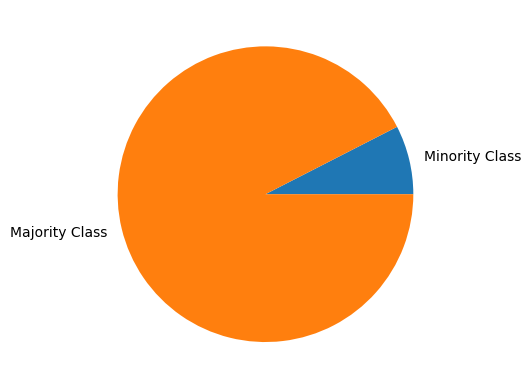

In [232]:
# Preprocessamento (Botando 1 tudo que é diferente de 0 como informado no grupo)
y_train[y_train != 0] = 1
y_test[y_test != 0] = 1
# Transformando 2D array em 1D array
y_train = y_train.flatten()
y_test = y_test.flatten()
# Criando gráfico de torta das diferenças entre as classes 0 e 1
class_division = [ y_train[y_train == 1].shape[0] , y_train[y_train == 0].shape[0] ]
my_labels = ['Minority Class', 'Majority Class']
plt.pie(class_division, labels = my_labels)
plt.show()

In [233]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(X_train,y_train)

GradientBoostingClassifier()

### Dataset original sem balanceamento

In [234]:
# Predição
y_pred = model.predict(X_test)

# Classification report conforme requisitado
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 93.61%
Confusion Matrix:
 [[8669  100]
 [ 512  301]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      8769
         1.0       0.75      0.37      0.50       813

    accuracy                           0.94      9582
   macro avg       0.85      0.68      0.73      9582
weighted avg       0.93      0.94      0.93      9582



In [235]:
# Pegando métricas da classe 1
from sklearn.metrics import precision_score, recall_score, f1_score
precision_original =  round(precision_score(y_test, y_pred), 4)
recall_original = round(recall_score(y_test, y_pred), 4)
f1_score_original =  round(f1_score(y_test, y_pred), 4)
metrics_original = [precision_original, recall_original, f1_score_original]

# Armazenando valores de teste do dataset sem balanceamento
original = pd.DataFrame(metrics_original)
original.index = ['Precision', 'Recall', 'F1_score']
original.columns = ['Original']
original

,Original
Precision,0.7506
Recall,0.3702
F1_score,0.4959


### Dataset com threshold de classificação diferenciado

In [236]:
cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:

    y_pred_new_threshold = (model.predict_proba(X_test)[:,1]>=i).astype(int) #calculating the threshold with respect to class 1

    precision_adj_threshold =  round(precision_score(y_test, y_pred_new_threshold, average='binary'), 4)
    recall_adj_threshold = round(recall_score(y_test, y_pred_new_threshold, average='binary'), 4)
    F1_score_adj_threshold =  round((f1_score(y_test, y_pred_new_threshold, average='binary')), 4)
    metrics_adj_threshold = [precision_adj_threshold, recall_adj_threshold, F1_score_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)


adj_threshold.index = ['Precision', 'Recall', 'F1_score']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

Metrics,Precision,Recall,F1_score
Original,0.7506,0.3702,0.4959
Threshold: 0.05,0.381,0.77,0.5098
Threshold: 0.1,0.5281,0.6814,0.5951
Threshold: 0.15,0.5942,0.6248,0.6091
Threshold: 0.2,0.6268,0.5867,0.6061
Threshold: 0.25,0.6504,0.556,0.5995
Threshold: 0.3,0.6725,0.5203,0.5867
Threshold: 0.35,0.6957,0.4809,0.5687
Threshold: 0.4,0.7242,0.449,0.5543
Threshold: 0.45,0.7335,0.4096,0.5257


### Resultados de melhor threshold por dataset
- A602: 0.5
- A621: 0.35
- A627: 0.45
- A636: 0.4
- A652: 0.15

In [238]:
y_pred = (model.predict_proba(X_test)[:,1]>=0.15).astype(int)

# Classification report conforme requisitado
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 93.20%
Confusion Matrix:
 [[8422  347]
 [ 305  508]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      8769
         1.0       0.59      0.62      0.61       813

    accuracy                           0.93      9582
   macro avg       0.78      0.79      0.79      9582
weighted avg       0.93      0.93      0.93      9582



In [239]:
# Juntando os resultados num novo dataframe
precision_changedthreshold =  round(precision_score(y_test, y_pred), 4)
recall_changedthreshold = round(recall_score(y_test, y_pred), 4)
F1_changedthreshold =  round(f1_score(y_test, y_pred), 4)
metrics_changedthreshold = [precision_changedthreshold, recall_changedthreshold, F1_changedthreshold]

changedthreshold = pd.DataFrame(list(zip(metrics_original, metrics_changedthreshold)))
changedthreshold.index = ['Precision', 'Recall', 'F1_score']
changedthreshold.columns = ['Original', 'Alteração de limiar']
changedthreshold

,Original,Alteração de limiar
Precision,0.7506,0.5942
Recall,0.3702,0.6248
F1_score,0.4959,0.6091


### Oversampling

In [240]:
X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)
train_data=pd.concat([X_train_df,y_train_df],axis=1) # Juntando os dados

Response_Zero= train_data[ train_data.iloc[:,24]==0 ] # Separando 2 dataframes baseado nas classificações
Response_One= train_data [ train_data.iloc[:,24]==1 ]

upsampled_One = resample(Response_One, # Igualando a quantidade de amostras com oversampling
                          replace=True,
                          n_samples=len(Response_Zero),
                          random_state=1)

upsampled = pd.concat([Response_Zero, upsampled_One])
upsampled.iloc[:,24].value_counts() # Checando se tudo ficou certo

0
0.0    9258
1.0    9258
Name: count, dtype: int64

In [241]:
#Treinando o modelo
X_train_upsampled = upsampled.iloc[:,:24]
y_train_upsampled = upsampled.iloc[:,24]

model.fit(X_train_upsampled,y_train_upsampled)

GradientBoostingClassifier()

In [242]:
# Predição
y_pred = model.predict(X_test)

# Classification report conforme requisitado
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 91.62%
Confusion Matrix:
 [[8259  510]
 [ 293  520]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.95      8769
         1.0       0.50      0.64      0.56       813

    accuracy                           0.92      9582
   macro avg       0.74      0.79      0.76      9582
weighted avg       0.93      0.92      0.92      9582



In [243]:
# Pegando métricas do oversampling
precision_upsampled =  round(precision_score(y_test, y_pred), 4)
recall_upsampled = round(recall_score(y_test, y_pred), 4)
F1_upsampled =  round(f1_score(y_test, y_pred), 4)
metrics_upsampled = [precision_upsampled, recall_upsampled, F1_upsampled]

upsampled = pd.DataFrame(list(zip(metrics_original, metrics_changedthreshold, metrics_upsampled)))
upsampled.index = ['Precision', 'Recall', 'F1_score']
upsampled.columns = ['Original', 'Alteração de limiar', 'Oversampling']
upsampled

,Original,Alteração de limiar,Oversampling
Precision,0.7506,0.5942,0.5049
Recall,0.3702,0.6248,0.6396
F1_score,0.4959,0.6091,0.5643


### Undersampling

In [244]:
X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)
train_data=pd.concat([X_train_df,y_train_df],axis=1) # Juntando os dados

Response_Zero= train_data[ train_data.iloc[:,24]==0 ] # Separando 2 dataframes baseado nas classificações
Response_One= train_data [ train_data.iloc[:,24]==1 ]

downsampled_Zero = resample(Response_Zero, # Igualando a quantidade de amostras com undersampling
                          replace=True,
                          n_samples=len(Response_One),
                          random_state=1)

downsampled = pd.concat([downsampled_Zero, Response_One])
downsampled.iloc[:,24].value_counts() # Checando se tudo ficou certo

0
0.0    754
1.0    754
Name: count, dtype: int64

In [245]:
#Treinando o modelo
X_train_downsampled = downsampled.iloc[:,:24]
y_train_downsampled = downsampled.iloc[:,24]

model.fit(X_train_downsampled,y_train_downsampled)

GradientBoostingClassifier()

In [246]:
# Predição
y_pred = model.predict(X_test)

# Classification report conforme requisitado
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 87.95%
Confusion Matrix:
 [[7833  936]
 [ 219  594]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.89      0.93      8769
         1.0       0.39      0.73      0.51       813

    accuracy                           0.88      9582
   macro avg       0.68      0.81      0.72      9582
weighted avg       0.92      0.88      0.90      9582



In [247]:
# Pegando métricas do undersampling
precision_downsampled =  round(precision_score(y_test, y_pred), 4)
recall_downsampled = round(recall_score(y_test, y_pred), 4)
F1_downsampled =  round(f1_score(y_test, y_pred), 4)
metrics_downsampled = [precision_downsampled, recall_downsampled, F1_downsampled]

downsampled = pd.DataFrame(list(zip(metrics_original, metrics_changedthreshold,  metrics_upsampled, metrics_downsampled)))
downsampled.index = ['Precision', 'Recall', 'F1_score']
downsampled.columns = ['Original', 'Alteração de limiar', 'Oversampling', 'Undersampling']
downsampled

,Original,Alteração de limiar,Oversampling,Undersampling
Precision,0.7506,0.5942,0.5049,0.3882
Recall,0.3702,0.6248,0.6396,0.7306
F1_score,0.4959,0.6091,0.5643,0.5070


In [196]:
#
#
#

### Resultados
Terminado a avaliação do primeiro dataset a ideia agora é aplicar o mesmo código nos outros 4 datasets gravando apenas o último dataframe de métricas para concluir o resultado.

In [172]:
#resultadosA602 = downsampled
resultadosA602

,Original,Alteração de limiar,Oversampling,Undersampling
Precision,0.4783,0.4783,0.3462,0.2492
Recall,0.5978,0.5978,0.7826,0.8370
F1_score,0.5314,0.5314,0.4800,0.3840


#### Conclusões A602:
- Nenhuma técnica de balanceamento agregou nos resultados do dataset A602

_______________________________________________________________________________________________

In [213]:
#resultadosA621 = downsampled
resultadosA621

,Original,Alteração de limiar,Oversampling,Undersampling
Precision,0.6830,0.6561,0.4022,0.3395
Recall,0.5699,0.6018,0.7715,0.8094
F1_score,0.6213,0.6278,0.5287,0.4783


#### Conclusões A621:
- A alteração de limiar agregou muito pouco nos resultados do dataset A621

_______________________________________________________________________________________________

In [230]:
#resultadosA627 = downsampled
resultadosA627

,Original,Alteração de limiar,Oversampling,Undersampling
Precision,0.6731,0.6333,0.3331,0.2831
Recall,0.5629,0.6025,0.7545,0.7842
F1_score,0.6131,0.6175,0.4621,0.4160


#### Conclusões A627:
- A alteração de limiar agregou muito pouco nos resultados do dataset A627

_______________________________________________________________________________________________

In [195]:
#resultadosA636 = downsampled
resultadosA636

,Original,Alteração de limiar,Oversampling,Undersampling
Precision,0.6063,0.5467,0.1679,0.1360
Recall,0.5563,0.6399,0.8800,0.9196
F1_score,0.5802,0.5896,0.2819,0.2370


#### Conclusões A636:
- A alteração de limiar agregou muito pouco nos resultados do dataset A636
_______________________________________________

In [248]:
resultadosA652 = downsampled
resultadosA652

,Original,Alteração de limiar,Oversampling,Undersampling
Precision,0.7506,0.5942,0.5049,0.3882
Recall,0.3702,0.6248,0.6396,0.7306
F1_score,0.4959,0.6091,0.5643,0.5070


#### Conclusões A652:
- A alteração de limiar agregou signitivamente nos resultados do dataset A652
_____________________________________________________

### Conclusão final do exercício 3 de balanceamento de dados
- Mudança de threshold tende a beneficiar nos resultados
- As técnicas de balanceamento tendem a reduzir a precisão e aumentar o recall dos resultados
- Muitas vezes as técnicas de over e under sampling reduzem a capacidade preditiva do modelo, principalmente undersampling

# 4 Calibração de modelos

### Resumo:
* Classificação | A602.pickle, A621.pickle, A627.pickle, A636.pickle, A652.pickle
* Preprocessamentos: binarização e balanceamentos (undersampling, oversampling e alteração de limiar)
* Mining: GradientBoostingClassifier
* Tarefa: comparar se o resultado dos datasets balanceados consegue ser melhor que os não balanceados